In [43]:
import hdbscan 
import zarr
import numpy as np
from sklearn.metrics.pairwise import euclidean_distances
from sklearn import metrics# import adjusted_rand_score, adjusted_mutual_info_score,silhouette_score
from tqdm import tqdm
import matplotlib.pyplot as plt
import networkx as nx
from scipy.signal import find_peaks
import pandas as pd
def make_network(hdb, df, wt_nan=1e12):
    G = nx.DiGraph()
    for row in hdb.condensed_tree_._raw_tree:
        if np.isfinite(row['lambda_val']):
            w = row['lambda_val']
            distance = 1 / row['lambda_val']
        else:
            w = wt_nan
            distance = None
        G.add_edge(int(row['parent']), int(row['child']), weight=w, distance=distance)

    # Assign attributes to existing nodes
    for i, (idx, row) in enumerate(df.iterrows()):
        nodeId = int(i)
        G.nodes[nodeId].update(row.to_dict())

    return G


def get_stable_eps(clusterer,indices,annotations,fields,excludes,eps_range = np.linspace(8e-3,4e-2,1024)):
    if len(indices) ==0:
        indices = np.ones(len(annotations)) > 0
    else:
        tmp = np.ones(len(annotations)) < 0
        tmp[indices] = True
        indices = tmp
     #
     
    valid_indices = [annotations[f]!= e for f,e in zip(fields,excludes)]

    stability_scores = []
    labels_prev = clusterer.dbscan_clustering(cut_distance=eps_range[0],min_cluster_size=2)
    for eps in tqdm(eps_range):
        labels = clusterer.dbscan_clustering(cut_distance=eps,min_cluster_size=2)
        core_cluster_idx = np.logical_and(labels > -1,indices)
        mi = metrics.mutual_info_score(labels_prev,labels)    
        tmp = [mi]+[metrics.adjusted_rand_score(labels[np.logical_and(idx,core_cluster_idx)],annotations[f].values[np.logical_and(idx,core_cluster_idx)]) for idx,f in zip(valid_indices,fields)]
        stability_scores += [tmp]
        labels_prev = labels
    stability_scores = np.array(stability_scores)    
    best_stability_index = np.argmax(stability_scores[:,0]) # use mutual infor
    return eps_range[best_stability_index],stability_scores

def stable_eps_detect(clusterer,vectors,stable_eps,eps_range = np.linspace(8e-3,4e-2,1024)):

   
    stable_eps1 = get_stable_eps(clusterer,vectors,eps_range)

    stability_scores = []
    labels_prev = clusterer.dbscan_clustering(cut_distance=stable_eps,min_cluster_size=2)
    idx=labels_prev>-1
    eps_range1 = np.linspace(np.min(eps_range),stable_eps1,512)
    for eps in tqdm(eps_range1):
        labels = clusterer.dbscan_clustering(cut_distance=eps,min_cluster_size=2)
        ami = metrics.adjusted_mutual_info_score(labels_prev[idx],labels[idx])
        stability_scores += [ami]
    stability_scores = np.array(stability_scores)    
    peaks, properties = find_peaks(np.diff(stability_scores), prominence=0.003,hieght = 0.003)

    return stable_eps1,eps_range1[peaks],stability_scores

import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

def detect_steps(data, method='zscore', window_size=5, threshold=2.0, 
                min_step_size=None, min_distance=10):
    """
    Detect significant step changes in 1D array using multiple methods.
    
    Parameters:
    -----------
    data : array-like
        1D input array
    method : str
        Detection method: 'zscore', 'gradient', or 'cumsum'
    window_size : int
        Size of rolling window for local statistics
    threshold : float
        Threshold for step detection (interpretation depends on method)
    min_step_size : float or None
        Minimum absolute size of step to be considered significant
    min_distance : int
        Minimum number of points between detected steps
        
    Returns:
    --------
    steps : numpy array
        Indices where steps were detected
    magnitudes : numpy array
        Magnitude of change at each detected step
    """
    x = np.array(data)
    step_candidates = []
    
    if method == 'zscore':
        # Detect steps using rolling z-score of differences
        diffs = np.diff(x)
        roll_mean = np.convolve(diffs, np.ones(window_size)/window_size, mode='valid')
        roll_std = np.array([np.std(diffs[i:i+window_size]) 
                           for i in range(len(diffs)-window_size+1)])
        z_scores = np.abs((diffs[window_size-1:] - roll_mean) / roll_std)
        
        # Find points where z-score exceeds threshold
        step_candidates = np.where(z_scores > threshold)[0] + window_size-1
        
    elif method == 'gradient':
        # Detect steps using gradient magnitude
        gradient = np.abs(np.gradient(x))
        roll_mean = np.mean(gradient)
        roll_std = np.std(gradient)
        threshold_value = roll_mean + threshold * roll_std
        step_candidates = np.where(gradient > threshold_value)[0]
        
    elif method == 'cumsum':
        # Detect steps using CUSUM algorithm
        mean = np.mean(x)
        cumsum = np.cumsum(x - mean)
        cumsum_range = np.max(cumsum) - np.min(cumsum)
        threshold_value = threshold * cumsum_range
        
        peaks, _ = find_peaks(np.abs(cumsum), height=threshold_value, 
                            distance=min_distance)
        step_candidates = peaks
    
    else:
        raise ValueError(f"Unknown method: {method}")
    
    # Calculate step sizes and filter by minimum size
    steps = []
    magnitudes = []
    
    for idx in step_candidates:
        if idx > window_size and idx < len(x)-window_size:
            step_size = abs(np.mean(x[idx:idx+window_size]) - 
                          np.mean(x[idx-window_size:idx]))
            
            if min_step_size is None or step_size >= min_step_size:
                # Check distance from previously detected steps
                if not steps or abs(idx - steps[-1]) >= min_distance:
                    steps.append(idx)
                    magnitudes.append(step_size)
                else:
                    # If two steps are too close, keep the larger one
                    if step_size > magnitudes[-1]:
                        steps[-1] = idx
                        magnitudes[-1] = step_size
    
    return np.array(steps), np.array(magnitudes)

def plot_steps(data, steps, magnitudes, title="Detected Steps"):
    """
    Plot the data and highlight detected steps.
    
    Parameters:
    -----------
    data : array-like
        Original 1D input array
    steps : array-like
        Indices of detected steps
    magnitudes : array-like
        Magnitude of changes at detected steps
    title : str
        Plot title
    """
    #plt.figure(figsize=(12, 6))
    plt.plot(data, 'b-', label='Data', alpha=0.7)
    
    # Plot vertical lines at step positions
    for step, magnitude in zip(steps, magnitudes):
        plt.axvline(x=step, color='r', linestyle='--', alpha=0.5)
        plt.text(step, plt.ylim()[1], f'Δ={magnitude:.2f}', 
                rotation=90, va='bottom')
    
    plt.title(title)
    plt.legend()
    plt.grid(True, alpha=0.3)
    #plt.show()



In [2]:
zarr_path = "/media/microscopie-lcb/swapnesh/protein/embeddings/phages/1Sept2024_INPHARED_db_latest/ESM2_3b_1Sept24_3b.zarr"
zarr_store = zarr.open(zarr_path,'r')
vectors = zarr_store['vectors_mean'][:]*1.0
accessions = zarr_store['accessions'][:]
vectors.shape,accessions[:5]

((24362, 2560),
 array(['AY319521', 'MW175890', 'GU339467', 'MF417929', 'MH616963'],
       dtype='<U50'))

In [3]:
annotations = pd.read_csv('../HieVi_INPHARED_ordered_annotation.csv')
annotations= annotations[annotations["Accession"].isin(accessions)]
annotations = annotations.set_index("Accession").loc[accessions].reset_index()
# annotations["Accession"] = pd.Categorical(annotations["Accession"], categories=accessions, ordered=True)
# annotations = annotations.sort_values("Accession")

annotations.head()

,Accession,Virus_Description,Virus_Genome_size,Virus_molGC_(%),Virus_Number_CDS,Realm,Kingdom,Phylum,Class,Order,...,VC_Subcluster_Size,VC_number,VC_subcluster,Adj P-value,Families in VC,Genera in VC,Genus Confidence Score,Orders in VC,Quality,Topology Confidence Score
0,AY319521,Salmonella phage SopEPhi,35155.0,51.3,45.0,Duplodnaviria,Heunggongvirae,Uroviricota,Caudoviricetes,Unclassified,...,44.0,4.0,0.0,1.0,0.0,0.0,1.0,0.0,0.9656,0.9656
1,MW175890,Dompiswa phage TSP7_1,150892.0,39.1,272.0,Duplodnaviria,Heunggongvirae,Uroviricota,Caudoviricetes,Unclassified,...,44.0,913.0,1.0,1.0,0.0,0.0,0.9683,0.0,0.7568,0.7568
2,GU339467,Mycobacterium phage RedRock,53332.0,64.5,90.0,Duplodnaviria,Heunggongvirae,Uroviricota,Caudoviricetes,Unclassified,...,5.0,221.0,1.0,0.99999997,0.0,0.0,1.0,0.0,0.0484,0.0484
3,MF417929,Uncultured Caudovirales phage clone 2F_1,32618.0,39.2,42.0,Duplodnaviria,Heunggongvirae,Uroviricota,Caudoviricetes,Unclassified,...,Unclassified,Unclassified,Unclassified,Unclassified,Unclassified,Unclassified,Unclassified,Unclassified,Unclassified,Unclassified
4,MH616963,crAssphage sp. isolate ctbg_1,94878.0,28.5,89.0,Duplodnaviria,Heunggongvirae,Uroviricota,Caudoviricetes,Crassvirales,...,16.0,703.0,1.0,1.0,0.0,0.0,0.725,0.0,0.8536,0.8536


In [4]:
annotations['Family'].unique()

array(['Peduoviridae', 'Unclassified', 'Intestiviridae', 'Demerecviridae',
       'Autographiviridae', 'Mesyanzhinovviridae', 'Inoviridae',
       'Autolykiviridae', 'Fiersviridae', 'Drexlerviridae',
       'Stanwilliamsviridae', 'Paulinoviridae', 'Microviridae',
       'Straboviridae', 'Grimontviridae', 'Arenbergviridae',
       'Casjensviridae', 'Herelleviridae', 'Schitoviridae',
       'Rountreeviridae', 'Ackermannviridae', 'Tectiviridae',
       'Orlajensenviridae', 'Chaseviridae', 'Vilmaviridae',
       'Salasmaviridae', 'Zobellviridae', 'Kyanoviridae',
       'Aliceevansviridae', 'Guelinviridae', 'Simuloviridae',
       'Zierdtviridae', 'Pungoviridae', 'Corticoviridae', 'Rudiviridae',
       'Steigviridae', 'Fredfastierviridae', 'Fuselloviridae',
       'Pleolipoviridae', 'Hafunaviridae', 'Vertoviridae', 'Suolaviridae',
       'Pyrstoviridae', 'Haloferuviridae', 'Soleiviridae',
       'Druskaviridae', 'Matshushitaviridae',
       'unclassified Autographiviridae', 'Forsetiviridae'

In [57]:
idx = annotations['Family'] == 'Straboviridae'
# idx = np.logical_or(idx,annotations['Family'] == 'Straboviridae')
# idx = np.logical_or(idx,annotations['Family'] == 'Inoviridae')
# idx = np.logical_or(idx,annotations['Family'] == 'Aliceevansviridae')
# idx = np.logical_or(idx,annotations['Family'] == 'Ackermannviridae')
# idx = np.logical_or(idx,annotations['Family'] == 'Peduoviridae')
# idx = np.logical_or(idx,annotations['Family'] == 'Autographiviridae')


#idx = annotations['Class'] == 'Caudoviricetes'

accessions=accessions[idx]
vectors = vectors[idx]
vectors.shape

TypeError: list indices must be integers or slices, not Series

In [67]:
idx = annotations['Virus_Number_CDS'] != 'Unclassified'
vectors = vectors[idx]
annotations = annotations[idx]
vectors= [v/a for v,a in zip(vectors,annotations['Virus_Number_CDS'].values.astype('float'))]

In [34]:
annotations.columns,len(np.where(annotations['Virus_Number_CDS'] == 'Unclassified')[0])

(Index(['Accession', 'Virus_Description', 'Virus_Genome_size',
        'Virus_molGC_(%)', 'Virus_Number_CDS', 'Realm', 'Kingdom', 'Phylum',
        'Class', 'Order', 'Family', 'Subfamily', 'Genus', 'Lowest_taxa',
        'Lowest_taxa_rank', 'Virus_Division', 'Host_Enveloppe',
        'Host_Isolation', 'Host_species', 'Host_superkingdom', 'Host_order',
        'Host_phylum', 'Identical_to', 'Jumbophage',
        'Low Coding Capacity Warning', 'Molecule_type', 'name',
        'Negative Strand (%)', 'Positive Strand (%)', 'tRNAs', 'VC_cluster',
        'VC', 'VC Status', 'VC_Size', 'VC_Subcluster', 'VC_Subcluster_Size',
        'VC_number', 'VC_subcluster', 'Adj P-value', 'Families in VC',
        'Genera in VC', 'Genus Confidence Score', 'Orders in VC', 'Quality',
        'Topology Confidence Score'],
       dtype='object'),
 331)

In [5]:
from sklearn.metrics.pairwise import cosine_distances
#Perform clustering
dist_scaled = euclidean_distances(vectors).astype("double")
clusterer = hdbscan.HDBSCAN(
    min_cluster_size=2,
    n_jobs=32,
    min_samples=1,
    allow_single_cluster=False,
    cluster_selection_method="leaf",
    metric="precomputed",
    gen_min_span_tree=True
)
clusterer.fit(dist_scaled)

# Perform clustering
# clusterer = hdbscan.HDBSCAN(
#     min_cluster_size=2,    
#     min_samples=1,
#     allow_single_cluster=False,
#     cluster_selection_method="leaf",
#     metric="euclidean",
#     gen_min_span_tree=True
# )
# clusterer.fit(vectors)


HDBSCAN(cluster_selection_method='leaf', gen_min_span_tree=True,
        metric='precomputed', min_cluster_size=2, min_samples=1)

In [42]:
selected = pd.read_csv('selected_accessions.csv',header = None)
selected_indices = np.array([np.where(accessions==s)[0] for s in selected.values])
selected_indices

array([[23186],
       [23303],
       [23194],
       ...,
       [22827],
       [22852],
       [22037]])

In [44]:
eps_range = np.linspace(1.5e-6,3e-4,1024)
eps_range = np.linspace(1.5e-3,3e-2,1024)

fields = ['VC_cluster','Genus','Subfamily','Family']
excludes = [-1] + ['Unclassified']*3 
stable_eps,stability_scores=get_stable_eps(clusterer,np.squeeze(selected_indices),annotations,fields,excludes,eps_range)
stable_eps

  0%|          | 0/1024 [00:00<?, ?it/s]

100%|██████████| 1024/1024 [01:07<00:00, 15.26it/s]


0.016209677419354838

In [47]:
optimal_epss = list(eps_range[np.argmax(stability_scores,axis = 0)[1:]])# + [eps_range[np.argmax(np.prod(stability_scores,axis = -1))]]
optimal_epss

[0.005929618768328445,
 0.007907624633431086,
 0.016432551319648093,
 0.022171554252199414]

/tmp/ipykernel_564007/2120114705.py:113: RuntimeWarning: invalid value encountered in divide
  z_scores = np.abs((diffs[window_size-1:] - roll_mean) / roll_std)


[0.0037287390029325513,
 0.004425219941348974,
 0.005511730205278592,
 0.008743401759530792,
 0.00930058651026393,
 0.011807917888563049,
 0.012755131964809383,
 0.013479472140762463,
 0.015457478005865102,
 0.016488269794721407,
 0.016961876832844575,
 0.017574780058651027,
 0.018744868035190616,
 0.02094574780058651,
 0.022422287390029327,
 0.023118768328445748,
 0.023954545454545454,
 0.02453958944281525,
 0.025291788856304988,
 0.026406158357771263,
 0.027548387096774193]

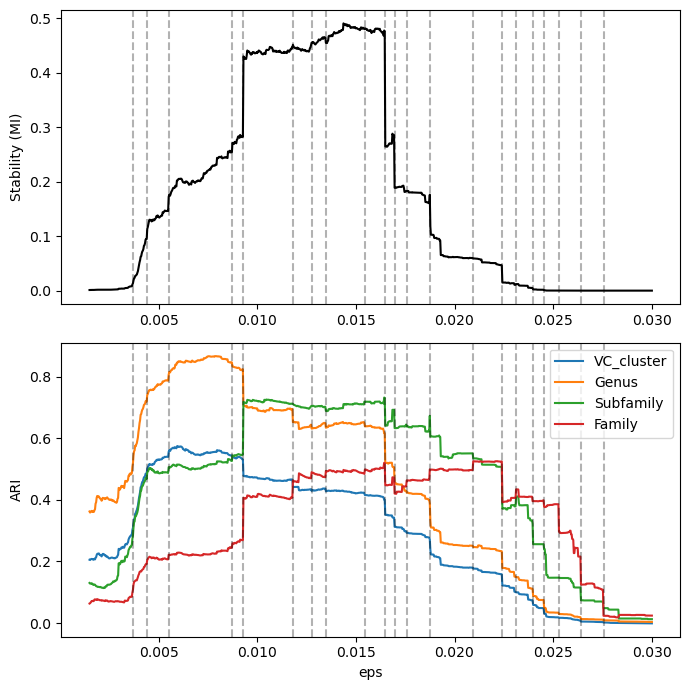

In [52]:
plt.figure(figsize=(7,7))
tmp = np.prod(stability_scores,axis = -1)
steps, magnitudes = detect_steps(stability_scores[:,-1], method='zscore', 
                                    window_size=2, threshold=0.3, 
                                    min_step_size=0.01,min_distance=16)
optimal_epss = list(eps_range[steps])

plt.subplot(2,1,1)
#plt.plot(eps_range,stability_scores[:,0],'k',label = "stability")
plt.plot(eps_range,np.prod(stability_scores,axis = -1),'k',label = "stability")
plt.ylabel('Stability (MI)')    
for e in optimal_epss:
    plt.axvline(e, color='k', linestyle='--', alpha=0.3)
plt.subplot(2,1,2)
for i in range(1,5):
    plt.plot(eps_range,stability_scores[:,i],label = fields[i-1])
for e in optimal_epss:
    plt.axvline(e, color='k', linestyle='--', alpha=0.3)
plt.legend()   
plt.xlabel('eps')
plt.ylabel('ARI')
plt.tight_layout()
optimal_epss

In [95]:
#optimal_epss = []
for i in range(1,5):
    # Detect steps using different methods
    steps, magnitudes = detect_steps(stability_scores[:,i], method='zscore', 
                                    window_size=2, threshold=0.25, 
                                    min_step_size=0.025,min_distance=32)
    # filter = stability_scores[steps,i] > 0.25
    # steps = steps[filter]
    # magnitudes = magnitudes[filter]

    # Plot results
    #plot_steps(stability_scores[:,i], steps, magnitudes, "Step Detection using Z-Score Method")
    optimal_epss += list(eps_range[steps])
optimal_epss = np.array(optimal_epss)
optimal_epss = np.unique(optimal_epss)
optimal_epss = np.sort(optimal_epss)

/tmp/ipykernel_559281/597153830.py:109: RuntimeWarning: invalid value encountered in divide
  z_scores = np.abs((diffs[window_size-1:] - roll_mean) / roll_std)


(array([0.00796334, 0.00815836, 0.01620968, 0.01643255, 0.02094575]),
 array([0.00793548, 0.00930059, 0.01180792, 0.01648827, 0.01874487,
        0.01877273, 0.01930205, 0.02242229, 0.0239824 , 0.02453959,
        0.02529179, 0.02640616, 0.02754839, 0.02832845]),
 [0.016209677419354838,
  0.0079633431085044,
  0.008158357771260998,
  0.016432551319648093,
  0.02094574780058651])

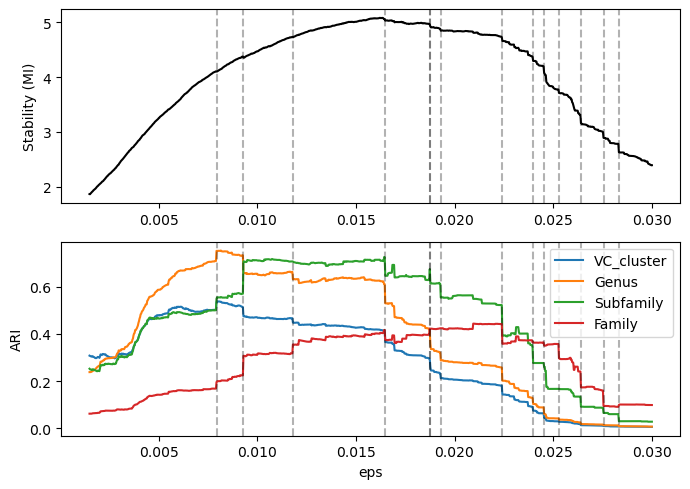

In [96]:

basic_epss = [stable_eps]
plt.figure(figsize=(7,5))
plt.subplot(2,1,1)
plt.plot(eps_range,stability_scores[:,0],'k',label = "stability")
for e in optimal_epss:
    plt.axvline(e, color='k', linestyle='--', alpha=0.3)
plt.ylabel('Stability (MI)')    
plt.subplot(2,1,2)
for i in range(1,5):
    plt.plot(eps_range,stability_scores[:,i],label = fields[i-1])
    basic_epss += [eps_range[np.argmax(stability_scores[:,i])]]
    #print(eps_range[np.argmax(stability_scores[:,i])])
basic_epss = np.unique(np.array(basic_epss)    )
# Mark each peak with a vertical line

for e in optimal_epss:
    plt.axvline(e, color='k', linestyle='--', alpha=0.3)
plt.legend()   
plt.xlabel('eps')
plt.ylabel('ARI')
plt.tight_layout()
#plt.savefig('/media/microscopie-lcb/swapnesh/Transfer/Hievi/plots/cluster_stability_3b.png')
#np.save(zarr_path[:-5] + '_eps_values_flat_clusters_3b.npy',optimal_epss)
basic_epss ,optimal_epss, [eps_range[np.argmax(stability_scores[:,i])] for i in range(5)]

In [38]:
import numpy as np
import networkx as nx

def make_network(hdb, df, wt_nan=1e12,min_lambda = None):
    """
    Constructs a directed graph from HDBSCAN's condensed tree.
    
    Parameters:
        hdb: HDBSCAN object with condensed_tree_ attribute.
        df (pd.DataFrame): Dataframe containing node attributes.
        wt_nan (float): Weight assigned when lambda_val is NaN.
    
    Returns:
        nx.DiGraph: A directed graph with nodes and edges from the condensed tree.
    """
    G = nx.DiGraph()
    
    # Add all nodes from the condensed tree
    all_nodes = set(hdb.condensed_tree_._raw_tree['parent']).union(set(hdb.condensed_tree_._raw_tree['child']))
    G.add_nodes_from(all_nodes)

    # Add edges with weights
    for row in hdb.condensed_tree_._raw_tree:
        parent, child, lambda_val = int(row['parent']), int(row['child']), row['lambda_val']
        weight = lambda_val if np.isfinite(lambda_val) else wt_nan
        if min_lambda is not None:
            if weight > min_lambda:
                G.add_edge(parent, child, weight=weight, distance=1 / weight if weight != 0 else wt_nan)
        else:
            G.add_edge(parent, child, weight=weight, distance=1 / weight if weight != 0 else wt_nan)

    # Assign attributes to existing nodes
    for i, (idx, row) in enumerate(df.iterrows()):
        node_id = int(i)
        if node_id in G.nodes:
            G.nodes[node_id].update(row.to_dict())

    return G

eps_val = optimal_epss
data={}
data['Accession'] = annotations['Accession'].values
data['HC_p0'] = clusterer.labels_
for i,e in enumerate(eps_val):
    data['HC_p' + str(i+1)] = clusterer.dbscan_clustering(cut_distance=e,min_cluster_size=2)

df = pd.DataFrame(data)
# Create and save network
#G = make_network(clusterer, annotations)
#nx.write_gexf(G, "/media/microscopie-lcb/swapnesh/protein/embeddings/HieVi.gexf")
#df.to_csv('/media/microscopie-lcb/swapnesh/protein/embeddings/HieVi.csv',index = None)


AttributeError: 'HDBSCAN' object has no attribute 'labels_'

In [33]:
#plt.savefig('/media/microscopie-lcb/swapnesh/Transfer/Hievi/plots/cluster_stability_3b.png')
np.save(zarr_path[:-5] + '_eps_values_flat_clusters.npy',optimal_epss)
df.to_csv(zarr_path[:-5] + '_flat_clusters.csv')

In [29]:
{d.keys for d in data}

[{'Accession': array(['AY319521', 'MW175890', 'GU339467', ..., 'PP461118', 'PP174317',
         'KY982929'], dtype=object)},
 {'HC_p0': array([  -1, 5346, 4342, ..., 5348, 5302,   -1])},
 {'HC_p1': array([  -1,  153,   -1, ..., 1076, 2087,   -1])},
 {'HC_p2': array([  -1,  150,  395, ..., 1066, 2085,   -1])},
 {'HC_p3': array([  -1,  469,  350, ...,  978, 1095,   52])},
 {'HC_p4': array([  -1,  414,  303, ...,  901, 1240,   50])},
 {'HC_p5': array([  -1,  348,  189, ...,  800, 1115,   38])},
 {'HC_p6': array([  -1,  305,   83, ...,  734, 1036,   32])},
 {'HC_p7': array([ -1, 269,  74, ..., 669, 958,  29])},
 {'HC_p8': array([ -1, 450,  70, ..., 629, 910,  30])},
 {'HC_p9': array([  -1,  396,   63, ...,  396,  396, 1029])},
 {'HC_p10': array([629, 365,  58, ..., 365, 365, 957])},
 {'HC_p11': array([487,  41,  41, ...,  41,  41, 743])},
 {'HC_p12': array([450,  40,  40, ...,  40,  40,  40])},
 {'HC_p13': array([406,  35,  35, ...,  35,  35,  35])}]

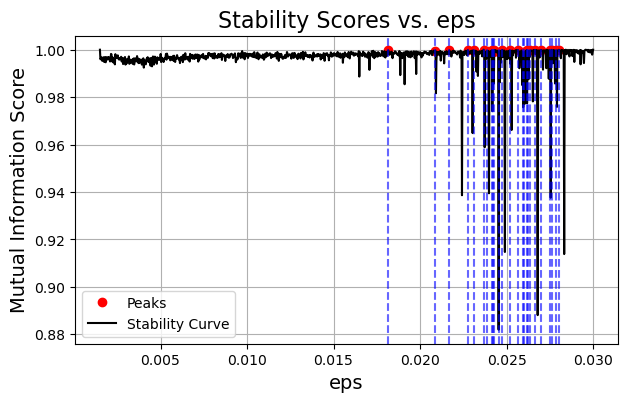

(array([0.01815982, 0.02089003, 0.02169795, 0.0227566 , 0.02309091,
        0.02367595, 0.02387097, 0.02414956, 0.02420528, 0.02428886,
        0.02456745, 0.02476246, 0.02518035, 0.02565396, 0.02593255,
        0.02598827, 0.02615543, 0.026239  , 0.0263783 , 0.02662903,
        0.0269912 , 0.02749267, 0.02760411, 0.02785484, 0.02802199]),
 0.02364809384164223)

In [182]:
# Assuming stability_scores and eps_range are precomputed
i = 0
peaks, _ = find_peaks(stability_scores[:, i], prominence=0.01)  # Identify peaks

# Plot stability scores and mark peaks
plt.figure(figsize=(7, 4))
plt.plot(eps_range[peaks], stability_scores[peaks, i], 'ro', label='Peaks')
plt.plot(eps_range, stability_scores[:, i], 'k', label='Stability Curve')

# Mark each peak with a vertical line
for peak in peaks:
    plt.axvline(eps_range[peak], color='blue', linestyle='--', alpha=0.6)

# Add labels and legend
plt.xlabel('eps', fontsize=14)
plt.ylabel('Mutual Information Score', fontsize=14)
plt.title('Stability Scores vs. eps', fontsize=16)
plt.legend()
plt.grid(True)
#plt.savefig('/media/microscopie-lcb/swapnesh/Transfer/Hievi/plots/cluster_stability.svg')
plt.show()

# Output peak details
optimal_eps = eps_range[peaks]
max_stable_eps = eps_range[np.argmax(stability_scores[1:-20, i])]  # Exclude boundary artifacts
optimal_eps, max_stable_eps

In [291]:
scores=[]
for eps in tqdm(optimal_eps):
    l = clusterer.dbscan_clustering(cut_distance=eps,min_cluster_size=2)
    scores +=[[metrics.silhouette_score(vectors,l)]]
scores = np.array(scores)
optimal_eps[np.argsort(scores[:,0])[::-1]]

100%|██████████| 25/25 [03:01<00:00,  7.27s/it]


array([0.01815982, 0.02089003, 0.02169795, 0.0227566 , 0.02309091,
       0.02367595, 0.02387097, 0.02414956, 0.02420528, 0.02428886,
       0.02456745, 0.02476246, 0.02518035, 0.02565396, 0.02593255,
       0.02598827, 0.02615543, 0.026239  , 0.0263783 , 0.02662903,
       0.0269912 , 0.02749267, 0.02760411, 0.02785484, 0.02802199])

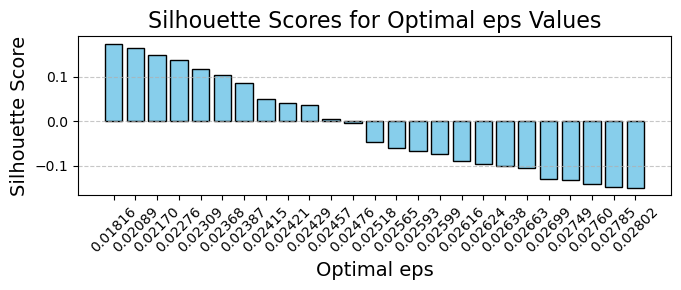

In [292]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming `optimal_eps` is an array of selected eps values
# and `scores` contains the silhouette score in the first column

# Bar plot for silhouette scores
plt.figure(figsize=(7, 3))
plt.bar(np.arange(len(optimal_eps)), scores[:, 0], color='skyblue', edgecolor='black')

# Set x-ticks to be the `optimal_eps` values
plt.xticks(np.arange(len(optimal_eps)), [f'{eps:.5f}' for eps in optimal_eps], rotation=45)

# Add labels, title, and formatting
plt.xlabel('Optimal eps', fontsize=14)
plt.ylabel('Silhouette Score', fontsize=14)
plt.title('Silhouette Scores for Optimal eps Values', fontsize=16)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Display the plot
plt.tight_layout()
#plt.savefig('/media/microscopie-lcb/swapnesh/Transfer/Hievi/plots/SilhouetteScoreEPS.svg')
plt.show()


In [46]:
idx = annotations['Family'] == 'Herelleviridae'
tmp = annotations[idx]
scores=[]
for eps in tqdm(optimal_eps):
    l = clusterer.dbscan_clustering(cut_distance=eps,min_cluster_size=2)
    l = l[idx]
    
    scores += [[metrics.normalized_mutual_info_score(tmp[f].values,l) for f in fields]]    
scores = np.array(scores)
scores.shape

  0%|          | 0/15 [00:00<?, ?it/s]


AttributeError: No single linkage tree was generated; try running fit first.

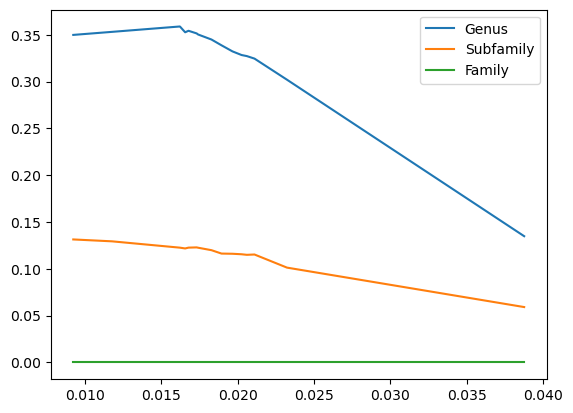

In [41]:
for i in range(scores.shape[-1]):
    plt.plot(optimal_eps,scores[:,i],label = fields[i])
plt.legend()    

In [23]:
df = pd.DataFrame({'Accession': accessions})
for i,eps in enumerate(optimal_epss):
    labels = clusterer.dbscan_clustering(cut_distance = eps,min_cluster_size = 2)
    df['HieVi_cluster_' + str(i)] = labels
df.head()    

,Accession,HieVi_cluster_0,HieVi_cluster_1,HieVi_cluster_2,HieVi_cluster_3,HieVi_cluster_4,HieVi_cluster_5,HieVi_cluster_6,HieVi_cluster_7,HieVi_cluster_8,HieVi_cluster_9,HieVi_cluster_10,HieVi_cluster_11,HieVi_cluster_12,HieVi_cluster_13,HieVi_cluster_14,HieVi_cluster_15,HieVi_cluster_16,HieVi_cluster_17
0,AY319521,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,437,422,368,327
1,MW175890,-1,678,733,753,743,720,1409,1330,1220,1171,1150,1091,1032,94,92,90,23,22
2,GU339467,-1,-1,-1,0,0,0,0,195,179,178,173,157,150,140,137,133,105,102
3,MF417929,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
4,MH616963,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,475


In [25]:
df.to_csv(zarr_path[:-4] + '_cluster.csv',index=None)

In [41]:
df = pd.DataFrame({'Accession': accessions})
G = make_network(clusterer,df)

In [ ]:
eps_range = np.linspace(8e-3,4e-2,512)
stable_eps = 0.016226783968719453
stability_scores = []
labels_prev = clusterer.dbscan_clustering(cut_distance=stable_eps,min_cluster_size=2)
idx=labels_prev>-1
eps_range1 = np.linspace(np.min(eps_range),stable_eps,512)

for eps in tqdm(eps_range1):
    labels = clusterer.dbscan_clustering(cut_distance=eps,min_cluster_size=2)
    ami = metrics.adjusted_mutual_info_score(labels_prev[idx],labels[idx])
    stability_scores += [ami]
stability_scores = np.array(stability_scores)    
peaks, properties = find_peaks(np.diff(stability_scores), prominence=0.003)
peaks

  0%|          | 0/512 [00:00<?, ?it/s]

100%|██████████| 512/512 [04:07<00:00,  2.07it/s]


array([], dtype=int64)

In [31]:
peaks, properties = find_peaks(np.diff(stability_scores), prominence=0.003)
peaks

array([ 80, 236])

array([0.00928795, 0.01179945])

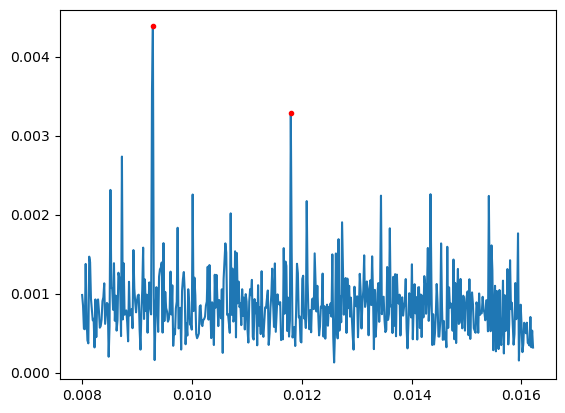

In [33]:
plt.plot(eps_range1[:-1],np.diff(stability_scores))
plt.plot(eps_range1[peaks],np.diff(stability_scores)[peaks],'r.')
eps_range1[peaks]

In [92]:
stable_epss = list(eps_range1[peaks])
stable_epss

[0.009287950523478583, 0.011799454044261823]

In [ ]:
vectors_exemplars = vectors
eps_range = np.linspace(8e-3,4e-2,1024)
stable_eps = stable_epss[0]
all_epss = []
for i in range(8):
    clusterer = hdbscan.HDBSCAN(
        min_cluster_size=2,
        min_samples=1,
        cluster_selection_epsilon=float(stable_eps),
        allow_single_cluster=False,
        cluster_selection_method="leaf",
        metric="euclidean",
        gen_min_span_tree=True
    )
    clusterer.fit(vectors_exemplars)
    exemplars=clusterer.exemplars_
    vectors_exemplars = np.concatenate([[e[0]] for e in exemplars],axis = 0)

    stable_eps,opt_eps,stability_scores = stable_eps_detect(clusterer,vectors_exemplars,stable_eps,eps_range = eps_range)
    stable_epss += [stable_eps]
    all_epss += [opt_eps]
    print(stable_eps)


100%|██████████| 512/512 [04:02<00:00,  2.11it/s]


0.016226783968719453


100%|██████████| 512/512 [00:18<00:00, 27.31it/s]


0.019573802541544477


100%|██████████| 512/512 [00:02<00:00, 228.12it/s]


0.024328445747800586


100%|██████████| 512/512 [00:00<00:00, 773.79it/s]


0.029239491691104593


100%|██████████| 512/512 [00:00<00:00, 1042.78it/s]


0.03671554252199413


100%|██████████| 512/512 [00:00<00:00, 1120.04it/s]


0.03699706744868035


100%|██████████| 512/512 [00:00<00:00, 5764.58it/s]


0.008


100%|██████████| 512/512 [00:00<00:00, 5814.43it/s]

0.008


In [94]:
np.unique(np.array(list(np.concatenate(all_epss[2:]))+stable_epss))

array([0.0080453 , 0.00809586, 0.00812469, 0.00822368, 0.00822649,
       0.00835149, 0.00837408, 0.00847564, 0.00849877, 0.00851126,
       0.00866503, 0.00872447, 0.00872478, 0.0088308 , 0.00899057,
       0.00911839, 0.00918229, 0.00927185, 0.00928795, 0.0092885 ,
       0.00935235, 0.00943793, 0.00946504, 0.00956574, 0.00963075,
       0.00967434, 0.00975746, 0.00982137, 0.00987989, 0.00991583,
       0.00998114, 0.01002852, 0.01003666, 0.01010896, 0.01018952,
       0.01020482, 0.01023781, 0.01026873, 0.01039654, 0.0106886 ,
       0.0107208 , 0.01074804, 0.01080852, 0.01092176, 0.01097839,
       0.01106757, 0.01118768, 0.01122734, 0.01138711, 0.01171449,
       0.01173506, 0.01176726, 0.01178238, 0.01179945, 0.01180251,
       0.01186642, 0.01207688, 0.01212205, 0.01232271, 0.01240964,
       0.01244741, 0.01266527, 0.01266576, 0.01277992, 0.01279309,
       0.0129602 , 0.01308067, 0.01317653, 0.01327239, 0.01343216,
       0.01352809, 0.01354908, 0.01365584, 0.01378366, 0.01391

In [91]:
np.concatenate([a for a in all_epss if len(a)])#+stable_epss

TypeError: object of type 'numpy.float64' has no len()

  0%|          | 0/1024 [00:00<?, ?it/s]

100%|██████████| 1024/1024 [00:41<00:00, 24.75it/s]


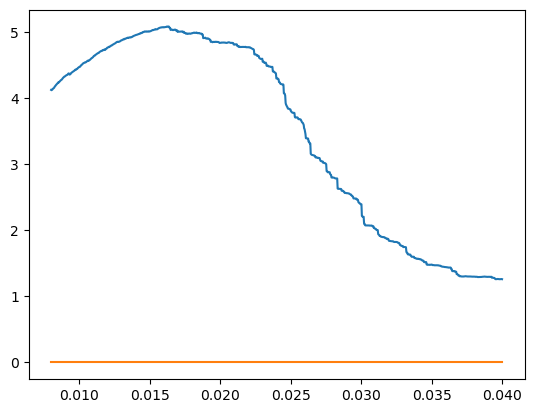

In [ ]:
eps_range = np.linspace(8e-3,4e-2,1024)
stability_scores = []
labels_prev = clusterer.dbscan_clustering(cut_distance=eps_range[0],min_cluster_size=2)
for eps in tqdm(eps_range):
    labels = clusterer.dbscan_clustering(cut_distance=eps,min_cluster_size=2)
    mi = metrics.mutual_info_score(labels_prev,labels)
    # idx = labels > -1
    # sil_score = metrics.silhouette_score(vectors[idx],labels[idx])
    sil_score = 0
    stability_scores += [[mi,sil_score]]
    labels_prev = labels
stability_scores = np.array(stability_scores)    
# Find eps values with high stability
plt.plot(eps_range,stability_scores[:,0])
#plt.plot(eps_range,stability_scores[:,1])
plt.show()
best_stability_index = np.argmax(stability_scores[:,0]) # use mutual infor
stable_eps = eps_range[best_stability_index]
    

In [54]:
clusterer = hdbscan.HDBSCAN(
    min_cluster_size=2,
    min_samples=1,
    cluster_selection_epsilon=float(stable_eps),
    allow_single_cluster=False,
    cluster_selection_method="leaf",
    metric="euclidean",
    gen_min_span_tree=True
)
clusterer.fit(vectors_exemplars)


HDBSCAN(cluster_selection_epsilon=0.029239491691104593,
        cluster_selection_method='leaf', gen_min_span_tree=True,
        min_cluster_size=2, min_samples=1)

In [55]:
exemplars=clusterer.exemplars_
#genus_eps = stable_eps
len(exemplars),exemplars[2].shape

(79, (2, 2560))

In [56]:

vectors_exemplars = np.concatenate([[e[0]] for e in exemplars],axis = 0)
vectors_exemplars.shape

(79, 2560)

 11%|█         | 109/1024 [00:00<00:00, 1084.34it/s]

100%|██████████| 1024/1024 [00:00<00:00, 1335.29it/s]


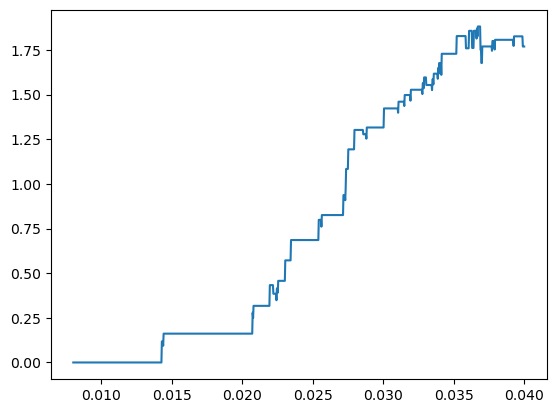

0.03671554252199413

In [57]:
# Perform clustering
dist_scaled = euclidean_distances(vectors_exemplars).astype("double")
clusterer = hdbscan.HDBSCAN(
    min_cluster_size=2,
    n_jobs=32,
    min_samples=1,
    allow_single_cluster=False,
    cluster_selection_method="leaf",
    metric="precomputed",
    gen_min_span_tree=True
)
clusterer.fit(dist_scaled)

eps_range = np.linspace(8e-3,4e-2,1024)
stability_scores = []
labels_prev = clusterer.dbscan_clustering(cut_distance=eps_range[0],min_cluster_size=2)
for eps in tqdm(eps_range):
    labels = clusterer.dbscan_clustering(cut_distance=eps,min_cluster_size=2)
    mi = metrics.mutual_info_score(labels_prev,labels)
    # idx = labels > -1
    # sil_score = metrics.silhouette_score(vectors[idx],labels[idx])
    sil_score = 0
    stability_scores += [[mi,sil_score]]
    labels_prev = labels
stability_scores = np.array(stability_scores)    
# Find eps values with high stability
plt.plot(eps_range,stability_scores[:,0])
#plt.plot(eps_range,stability_scores[:,1])
plt.show()
best_stability_index = np.argmax(stability_scores[:,0]) # use mutual infor
stable_eps = eps_range[best_stability_index]
stable_eps

In [45]:
genus_eps

0.016226783968719453

In [60]:

eps_values = [0.016226783968719453,0.019573802541544477,0.024328445747800586,0.029239491691104593,0.03671554252199413]
tmp = {f'HieVi_rank_{i+1}':clusterer.dbscan_clustering(cut_distance=eps,min_cluster_size=2) for i,eps in enumerate(eps_values)}
df = pd.DataFrame(tmp)
df['Accession'] = accessions
df.to_csv(zarr_path + '.csv')



In [ ]:
clusterer = hdbscan.HDBSCAN(
    min_cluster_size=2,
    min_samples=1,
    cluster_selection_epsilon=float(stable_eps),
    allow_single_cluster=False,
    cluster_selection_method="leaf",
    metric="euclidean",
    gen_min_span_tree=True
)
clusterer.fit(np.concatenateexemplars,a)

In [13]:
eps_range = np.linspace(8e-3,4e-2,512)
eps_range = np.linspace(1e-2,5e-2,512)
labels_prev = clusterer.labels_
stability_scores = []

from joblib.parallel import delayed,Parallel

# def scoring_func(eps):
#     labels = clusterer.dbscan_clustering(cut_distance=eps,min_cluster_size=2)
#     ami = adjusted_mutual_info_score(labels_prev,labels)
#     ari = adjusted_rand_score(labels_prev,labels)
#     return [ami,ari]
# stability_scores = Parallel(32)([scoring_func(eps) for eps in tqdm(eps_range)])

stability_scores = []
labels_prev = clusterer.dbscan_clustering(cut_distance=stable_eps,min_cluster_size=2)
idx=labels_prev>-1
for eps in tqdm(eps_range):
    labels = clusterer.dbscan_clustering(cut_distance=eps,min_cluster_size=2)
    ami = metrics.adjusted_mutual_info_score(labels_prev[idx],labels[idx])
    ari = metrics.adjusted_rand_score(labels[idx],labels_prev[idx])
    ri = metrics.rand_score(labels_prev[idx],labels[idx])
    mi = metrics.mutual_info_score(labels_prev[idx],labels[idx])
    #sil_score = silhouette_score(vectors,labels)
    stability_scores += [[ari,ami,ri,mi,len(np.where(labels>-1)[0])/len(labels)]]
    #labels_prev = labels

stability_scores = np.array(stability_scores)    
stability_scores.shape

  0%|          | 0/512 [00:00<?, ?it/s]

100%|██████████| 512/512 [02:05<00:00,  4.09it/s]


(512, 5)

Best eps for stable clustering: 0.0161839530332681


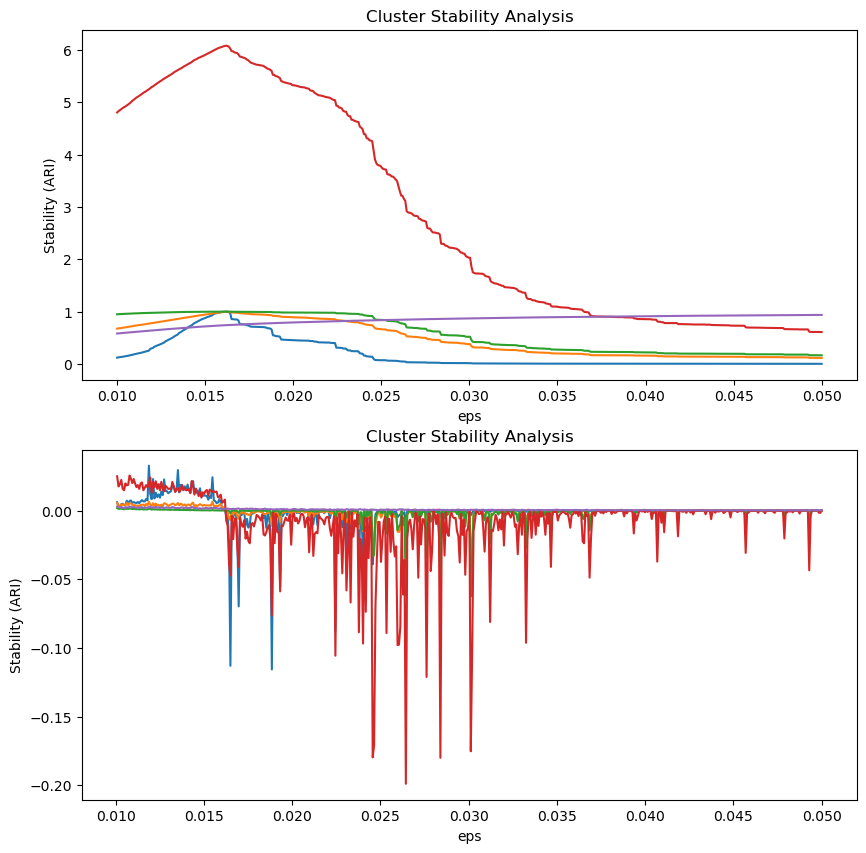

In [14]:
# Find eps values with high stability
best_stability_index = np.argmax(stability_scores[:,3])
best_eps = eps_range[best_stability_index]

print(f"Best eps for stable clustering: {best_eps}")

# Plot stability scores
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
plt.subplot(2,1,1)
for i in range(stability_scores[:,:].shape[-1]):
    plt.plot(eps_range, stability_scores[:,i])

plt.xlabel("eps")
plt.ylabel("Stability (ARI)")
plt.title("Cluster Stability Analysis")
plt.subplot(2,1,2)
for i in range(stability_scores.shape[-1]):
    plt.plot(eps_range[1:], np.diff(stability_scores[:,i]))

plt.xlabel("eps")
plt.ylabel("Stability (ARI)")
plt.title("Cluster Stability Analysis")
plt.show()

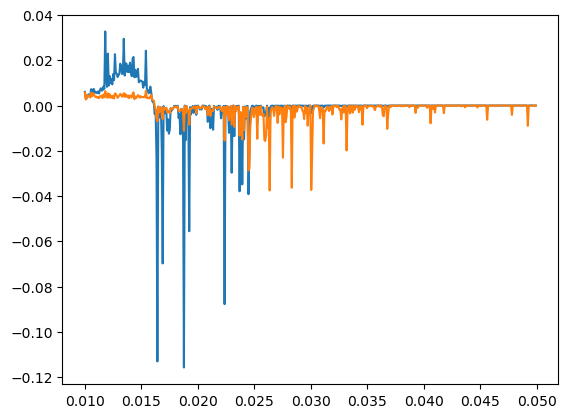

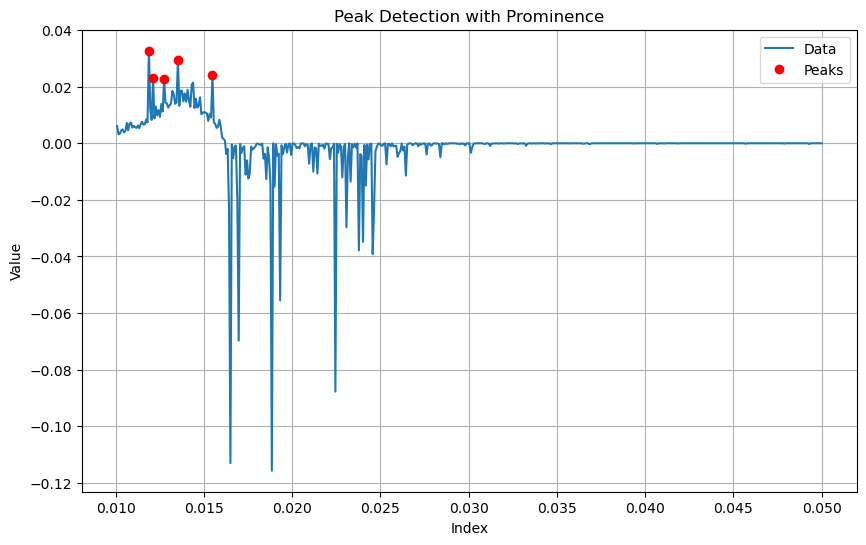

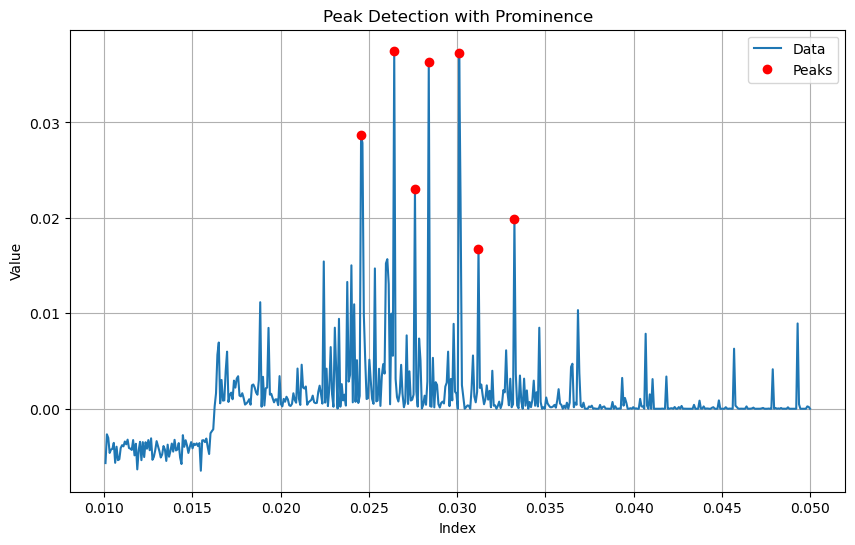

In [21]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

def find_and_plot_peaks(x,data, prominence=1.0):
    """
    Find peaks in a 1D array based on prominence and plot the results.

    Parameters:
        data (array-like): The input 1D data array.
        prominence (float): The required prominence of peaks.

    Returns:
        peaks (array): Indices of the peaks in the data.
        properties (dict): Properties of the peaks (from scipy.signal.find_peaks).
    """
    # Find peaks with the specified prominence
    peaks, properties = find_peaks(data, prominence=prominence,height=0.005)

    # Plot the data and highlight the peaks
    plt.figure(figsize=(10, 6))
    plt.plot(x,data, label="Data", linewidth=1.5)
    plt.plot(x[peaks], data[peaks], "ro", label="Peaks")
    
    # Annotate peaks with their prominence values
    for peak, prom in zip(peaks, properties['prominences']):
        plt.annotate(f'{prom:.2f}', (peak, data[peak]),
                     textcoords="offset points", xytext=(0, 10), ha='center')

    plt.title("Peak Detection with Prominence")
    plt.xlabel("Index")
    plt.ylabel("Value")
    plt.legend()
    plt.grid(True)
    plt.show()

    return x[peaks], properties

import networkx as nx
def make_network(hdb, df, wt_nan=1e12):
    G = nx.DiGraph()
    for row in hdb.condensed_tree_._raw_tree:
        if np.isfinite(row['lambda_val']):
            w = row['lambda_val']
            #row['distance'] = 1 / row['lambda_val']  # Add distance attribute
            
        else:
            w = wt_nan
        G.add_edge(int(row['parent']), int(row['child']), weight=w)

    # Assign attributes to existing nodes
    for i, (idx, row) in enumerate(df.iterrows()):
        nodeId = int(i)
        G.nodes(data=True)[nodeId].update(row.to_dict())
    return G

import pandas as pd
plt.plot(eps_range[:-1],np.diff(stability_scores[:,0]))
plt.plot(eps_range[:-1],np.diff(stability_scores[:,1]))
opt_eps,_=find_and_plot_peaks(eps_range[1:],np.diff(stability_scores[:,0]), prominence=0.01)
opt_eps1,_=find_and_plot_peaks(eps_range[1:],-np.diff(stability_scores[:,1]), prominence=stable_eps)
opt_epss = np.sort(np.concatenate((opt_eps,opt_eps1)))

In [65]:
opt_epss

array([0.01187867, 0.0121135 , 0.01273973, 0.0135225 , 0.01547945,
       0.02455969, 0.02643836, 0.02761252, 0.0283953 , 0.03011742,
       0.03121331, 0.03324853])

100%|██████████| 12/12 [02:40<00:00, 13.36s/it]


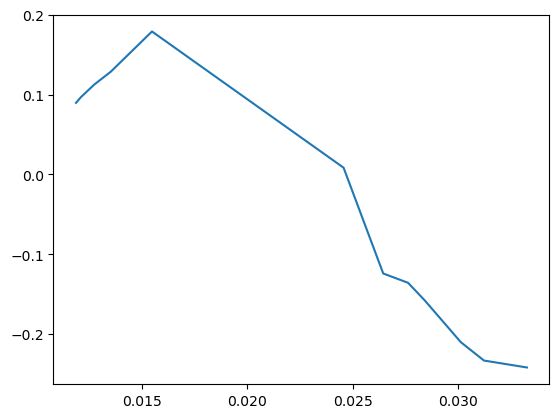

In [22]:
silscore = []
for eps in tqdm(opt_epss):
    labels = clusterer.dbscan_clustering(cut_distance=eps,min_cluster_size=2)
    sil = metrics.silhouette_score(vectors,labels)
    silscore +=[sil]
silscore = np.array(silscore)
plt.plot(opt_epss,silscore)    

In [23]:
tmp = {f'HieVi_rank_{i+1}':clusterer.dbscan_clustering(cut_distance=eps,min_cluster_size=2) for i,eps in enumerate(opt_epss)}
df = pd.DataFrame(tmp)
df['Accession'] = accessions
df.to_csv(zarr_path + '.csv')


In [ ]:
import networkx as nx
def make_network(hdb, df, wt_nan=1e12):
    G = nx.DiGraph()
    for row in hdb.condensed_tree_._raw_tree:
        if np.isfinite(row['lambda_val']):
            w = row['lambda_val']            
        else:
            w = wt_nan
        G.add_edge(int(row['parent']), int(row['child']), weight=w)

    # Assign attributes to existing nodes
    for i, (idx, row) in enumerate(df.iterrows()):
        nodeId = int(i)
        G.nodes(data=True)[nodeId].update(row.to_dict())
    return G
import pandas as pd
df = pd.DataFrame({'Labels':clusterer.dbscan_clustering(cut_distance=0.04580645,min_cluster_size=2)})
G = make_network(clusterer,df)
nx.write_gexf(G,zarr_path + '.gexf')
df = pd.DataFrame({'Labels1':clusterer.dbscan_clustering(cut_distance=0.02412903225806452,min_cluster_size=2),'Accession':zarr_store['accessions'][:]})
df.to_csv(zarr_path + '.csv')

In [191]:
tmp = {f'Labels_{i}':clusterer.dbscan_clustering(cut_distance=eps,min_cluster_size=2) for i,eps in enumerate(opt_eps)}
df = pd.DataFrame(tmp)
df['Accession'] = zarr_store['accessions'][:]
df.to_csv(zarr_path + '.csv')

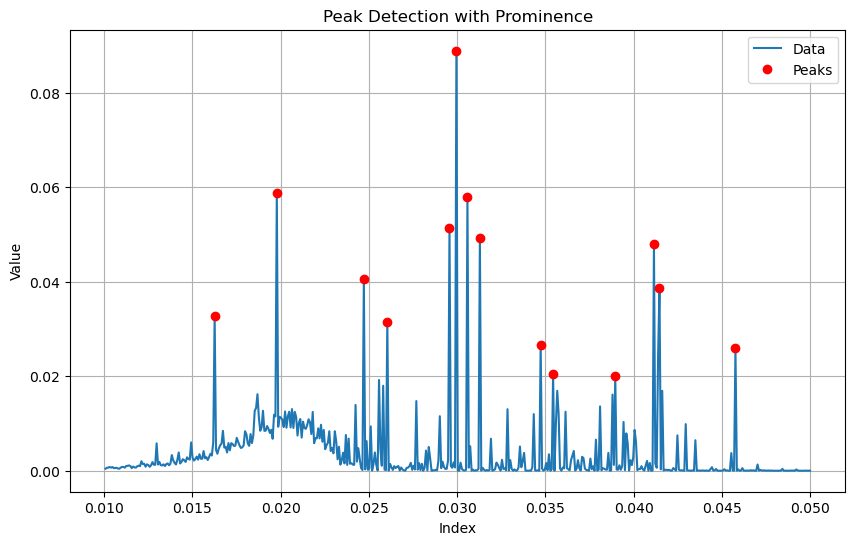

In [190]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

def find_and_plot_peaks(x,data, prominence=1.0):
    """
    Find peaks in a 1D array based on prominence and plot the results.

    Parameters:
        data (array-like): The input 1D data array.
        prominence (float): The required prominence of peaks.

    Returns:
        peaks (array): Indices of the peaks in the data.
        properties (dict): Properties of the peaks (from scipy.signal.find_peaks).
    """
    # Find peaks with the specified prominence
    peaks, properties = find_peaks(data, prominence=prominence)

    # Plot the data and highlight the peaks
    plt.figure(figsize=(10, 6))
    plt.plot(x,data, label="Data", linewidth=1.5)
    plt.plot(x[peaks], data[peaks], "ro", label="Peaks")
    
    # Annotate peaks with their prominence values
    for peak, prom in zip(peaks, properties['prominences']):
        plt.annotate(f'{prom:.2f}', (peak, data[peak]),
                     textcoords="offset points", xytext=(0, 10), ha='center')

    plt.title("Peak Detection with Prominence")
    plt.xlabel("Index")
    plt.ylabel("Value")
    plt.legend()
    plt.grid(True)
    plt.show()

    return x[peaks], properties

opt_eps,_=find_and_plot_peaks(eps_range[1:],np.abs(np.diff(stability_scores[:,0])), prominence=0.02)


In [91]:
# Extract lambda values for prominent clusters
condensed = clusterer.condensed_tree_.to_pandas()
prominent_clusters = condensed[(condensed['child_size'] > 32) & (condensed['child_size'] < 64)]  # Clusters with significant size
lambda_vals = prominent_clusters['lambda_val']
child_size = prominent_clusters['child_size']

# Convert lambda values to eps candidates
eps_candidates = 1 / lambda_vals
print(f"Candidate eps values: {eps_candidates}")

Candidate eps values: 73       0.145830
283      0.124899
289      0.051854
293      0.033397
532      0.114809
           ...   
35934    0.004623
35948    0.004465
35961    0.004378
35985    0.004295
35992    0.004258
Name: lambda_val, Length: 657, dtype: float64


In [112]:
condensed = clusterer.condensed_tree_.to_pandas()
prominent_clusters = condensed[(condensed['child_size'] > 2)]  # Clusters with significant size
lambda_vals = prominent_clusters['lambda_val']
child_size = prominent_clusters['child_size']
prominent_clusters['distance'] = 1/lambda_vals
prominent_clusters

/tmp/ipykernel_2401667/4073425299.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prominent_clusters['distance'] = 1/lambda_vals


,parent,child,lambda_val,child_size,distance
3,24362,24363,4.877057,24357,0.205042
5,24363,24365,4.884631,24355,0.204724
12,24365,24367,5.146198,24352,0.194318
26,24367,24369,6.168518,24320,0.162114
27,24367,24370,6.168518,22,0.162114
...,...,...,...,...,...
36022,36037,36040,277.368991,3,0.003605
36026,36039,36042,278.352530,10,0.003593
36030,36042,36043,290.389835,8,0.003444
36037,36043,36045,300.757824,4,0.003325


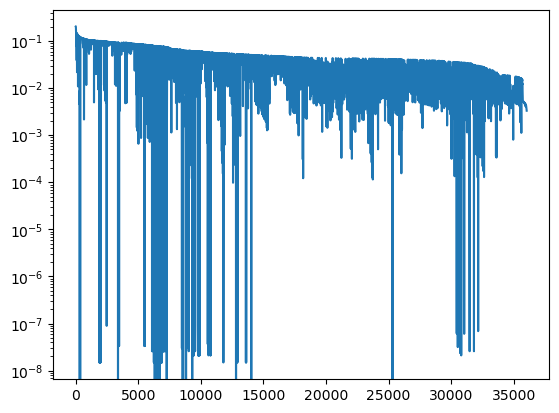

In [127]:
plt.semilogy(prominent_clusters['distance'])

In [119]:
parent_nodes = set(prominent_clusters['parent'])
stats = []
for p in parent_nodes:
    idx = prominent_clusters['parent'] ==p
    total_childern = prominent_clusters[idx]['child_size'].sum()
    distance_mean = prominent_clusters[idx]['distance'].mean()
    distance_std = np.nanstd(prominent_clusters[idx]['distance'])
    stats += [[distance_mean,distance_std,total_childern]]
stats = np.array(stats)
stats.shape

(5475, 3)

In [120]:
distance_std

0.0

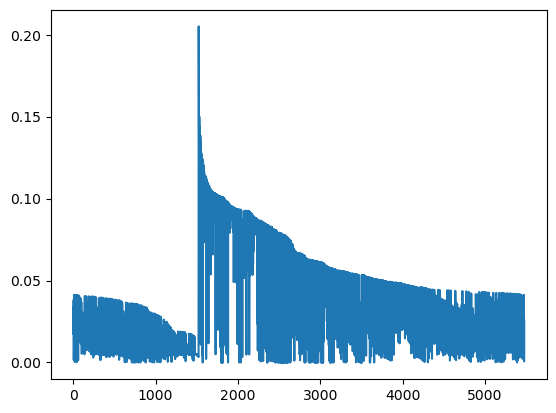

In [122]:
plt.plot(stats[:,0])

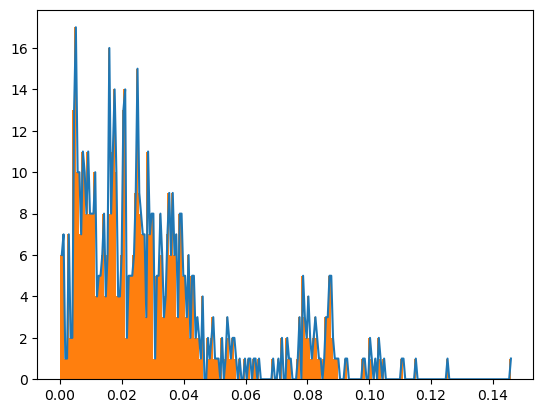

In [92]:
binsize = 256
h,b = np.histogram(eps_candidates,binsize,density=False)
plt.plot(b[1:],h)
plt.hist(eps_candidates,binsize);

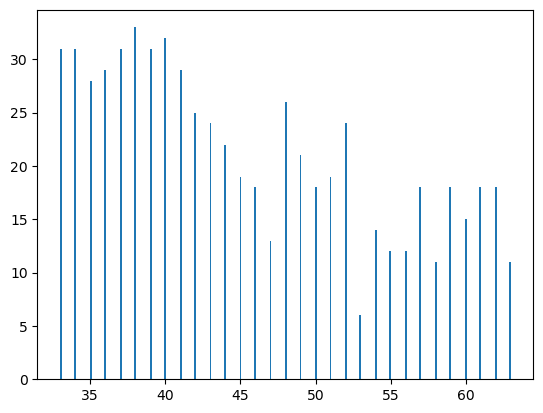

In [93]:
plt.hist(child_size,binsize);

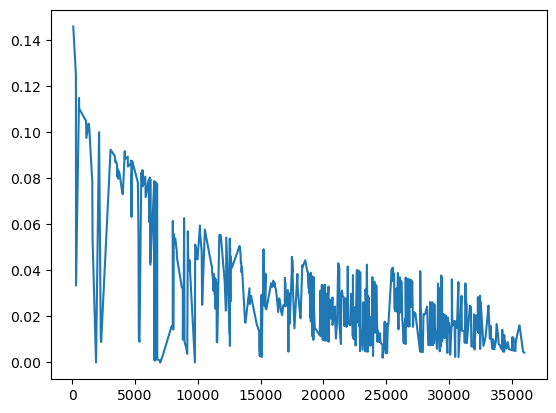

In [94]:
plt.plot(eps_candidates)

In [53]:

stability_scores = []
labels_prev = clusterer.dbscan_clustering(cut_distance=eps_range[0],min_cluster_size=2)
for eps in tqdm(eps_candidates):
    labels = clusterer.dbscan_clustering(cut_distance=eps,min_cluster_size=2)
    ami = adjusted_mutual_info_score(labels_prev,labels)
    ari = adjusted_rand_score(labels_prev,labels)
    #sil_score = silhouette_score(vectors,labels)
    stability_scores += [[ari,ami]]
    #labels_prev = labels

stability_scores = np.array(stability_scores)    
stability_scores.shape

100%|██████████| 1176/1176 [04:19<00:00,  4.54it/s]


(1176, 2)

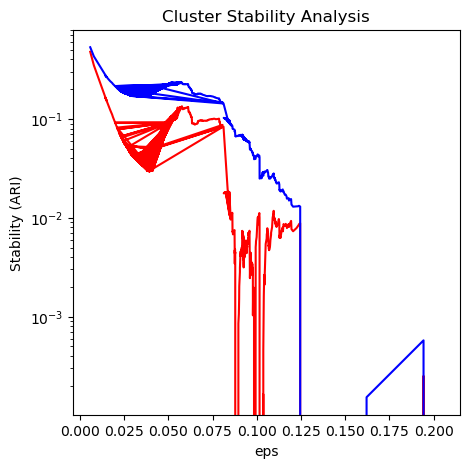

In [56]:
# Plot stability scores
import matplotlib.pyplot as plt
plt.figure(figsize=(5,5))
plt.semilogy(eps_candidates, stability_scores[:,0],'r')
plt.semilogy(eps_candidates, stability_scores[:,1],'b')
plt.xlabel("eps")
plt.ylabel("Stability (ARI)")
plt.title("Cluster Stability Analysis")
plt.show()